# Visualization of Performance Benchmarks mentioned in the Paper
> Author: Tianyu Du
> 
> July 18, 2023

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import re
plt.style.use(["science", "bright"])

In [12]:
def transform_time_to_ratio(df):
    # get baseline runtime, the smallest runtime for the formula (the smallest configuration).
    m = df.groupby('formula')['time'].min().rename('min_time').reset_index()
    df = df.merge(m, on='formula', how='left')
    # normalize the runtime by the baseline runtime to report ratio.
    df['time'] = df['time'] / df['min_time']
    return df

In [13]:
REPORT_RATIO = False
if REPORT_RATIO:
    # report the runtime as a ratio to the baseline runtime.
    # this metric is more helpful to illustrate the scalability.
    Y_LABEL = "Time as a Ratio to the Baseline"
else:
    # report the actual runtime in seconds.
    # this metric is more helpful to illustrate the performance of `torch-choice` over R.
    Y_LABEL = "Time (seconds)"

In [14]:
# Parse R formula to python formula.
def parse_r_formula(formula):
    # convert r formula to the python formula.
    if "user_latent_0" in formula and "item_latent_0" not in formula:
        # user latent only, Equation (27).
        return "(user_latents|item)"
    elif "item_latent_0" in formula and "user_latent_0" not in formula:
        # item latent only, Equation (26).
        return "(item_latents|constant)"
    elif "user_latent_0" in formula and "item_latent_0" in formula:
        # both user and item latent, Equation (28).
        return "(user_latents|item) + (item_latents|constant)"
    else:
        raise ValueError("Unknown formula: {}".format(formula))

In [15]:
# Parse the formula to the latex representation in figure legend.
def generate_latex_representation_formula(input_formula):
    if input_formula == "(item_latents|constant)":
        return "$\\mu_{uis} = \\beta^\\top Z_i$"
    elif input_formula == "(user_latents|item)":
        return "$\\mu_{uis} = \\alpha_i^\\top X_u$"
    elif input_formula == "(user_latents|item) + (item_latents|constant)":
        return "$\\mu_{uis} = \\alpha_i^\\top X_u + \\beta^\\top Z_i$"

In [16]:
# configurations for the plots.
font = {'size': 22}
matplotlib.rc('font', **font)


plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.loc"] = "upper left"
plt.rcParams["figure.dpi"] = 500

In [17]:
file_appendix = "_LBFGS"  # compare with torch-choice with LBFGS optimizer.

# Performance by Number of Records ($N$)

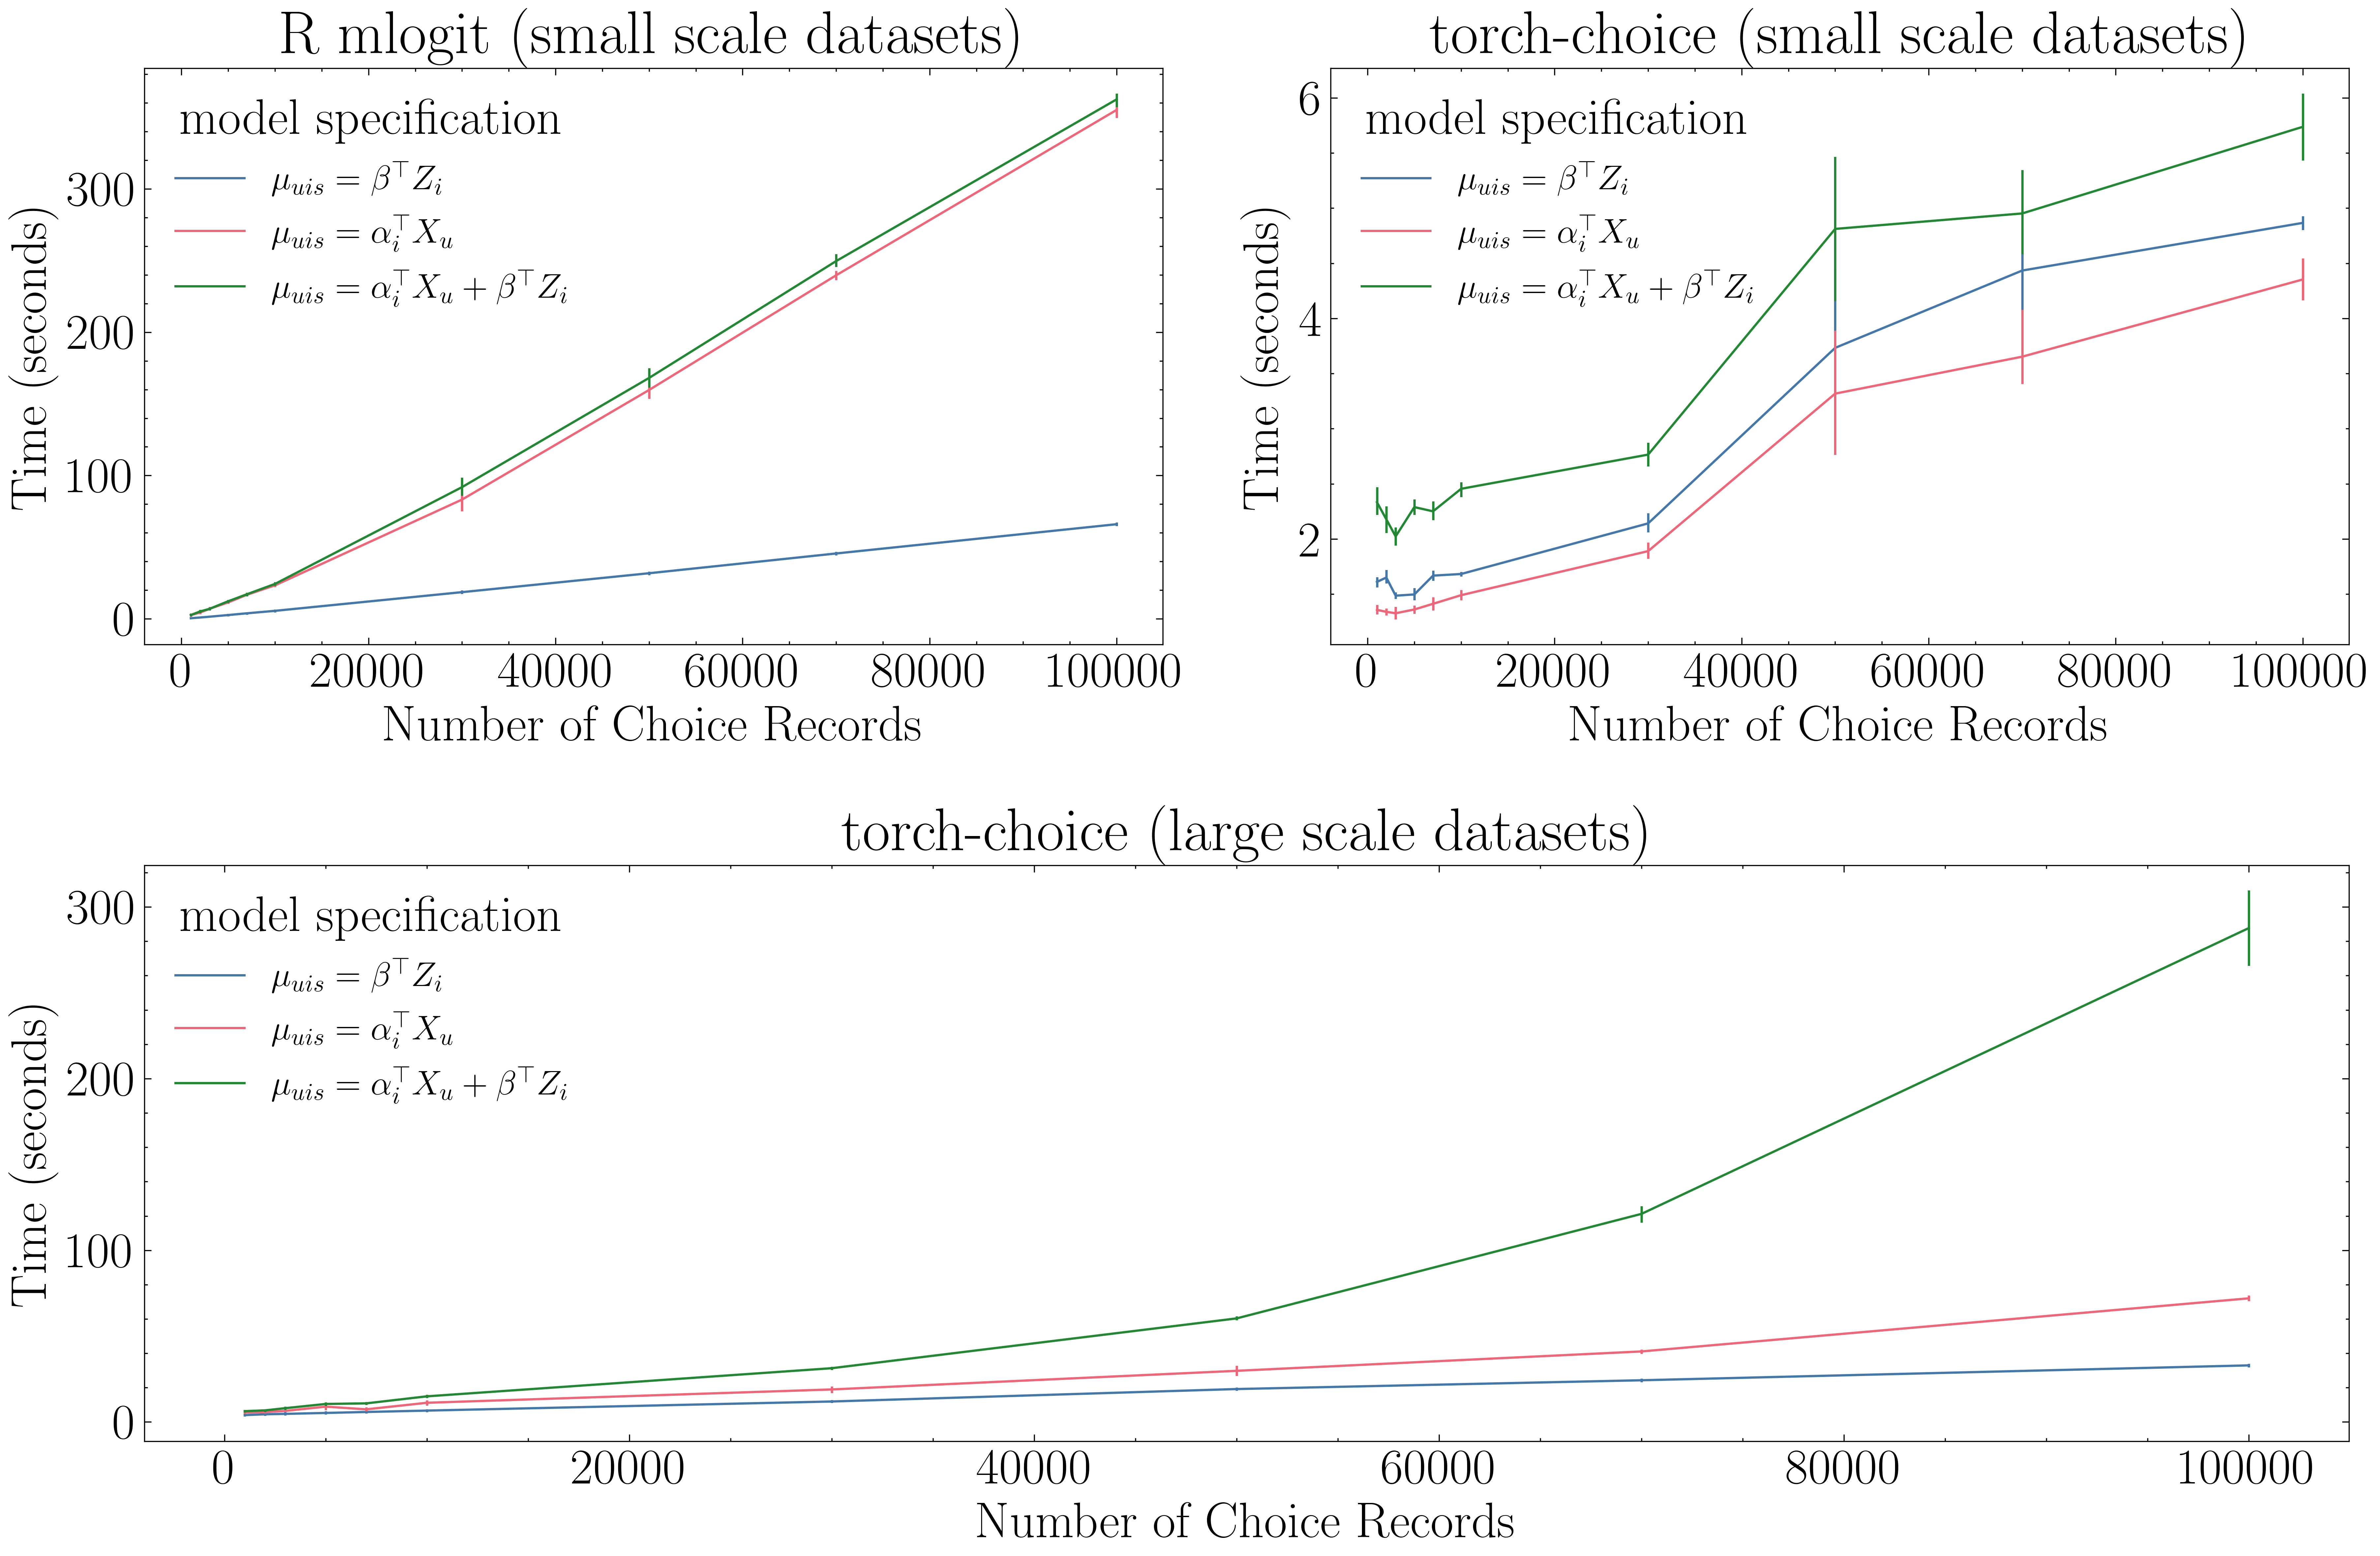

In [18]:
df_r = pd.read_csv("R_performance_num_records.csv")
df_r["package"] = "R"
df_python = pd.read_csv(f"Python_num_records_experiment_small{file_appendix}.csv").rename(columns={"sample_size": "num_records"}).query("num_records <= 100000")  # experiments with R has <= 100000 records.
df_python["package"] = "Python"

if REPORT_RATIO:
    df_r = transform_time_to_ratio(df_r)
    df_python = transform_time_to_ratio(df_python)

df_r["formula"] = df_r["formula"].apply(parse_r_formula)

fig = plt.figure(tight_layout=True, figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)
axes = list()
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, :]))
for i in range(3):
    axes[i].set_xlabel("Number of Choice Records")
    axes[i].set_ylabel(Y_LABEL)

axes[0].set_title("R mlogit (small scale datasets)")
axes[1].set_title("torch-choice (small scale datasets)")
axes[2].set_title("torch-choice (large scale datasets)")

df_r["model specification"] = df_r["formula"].apply(generate_latex_representation_formula)
df_python["model specification"] = df_python["formula"].apply(generate_latex_representation_formula)

sns.lineplot(x="num_records", y="time", hue="model specification", err_style="bars", data=df_r.sort_values(by="formula"), ax=axes[0])
sns.lineplot(x="num_records", y="time", hue="model specification", err_style="bars", data=df_python.sort_values(by="formula"), ax=axes[1])

df = pd.read_csv(f"Python_num_records_experiment_large{file_appendix}.csv").rename(columns={"sample_size": "num_records"}).query("num_records <= 100000")  # the runtime is pretty much flat after 100000 records, not very informative.
df["model specification"] = df["formula"].apply(generate_latex_representation_formula)
if REPORT_RATIO:
    df = transform_time_to_ratio(df)
sns.lineplot(x="num_records", y="time", hue="model specification", err_style="bars", data=df.sort_values(by="formula"), ax=axes[2])

fig.savefig(f"./figures/num_record_comparisons{file_appendix}_{'ratio' if REPORT_RATIO else 'abs'}.png", bbox_inches="tight")

# Performance by Number of Features ($P$)

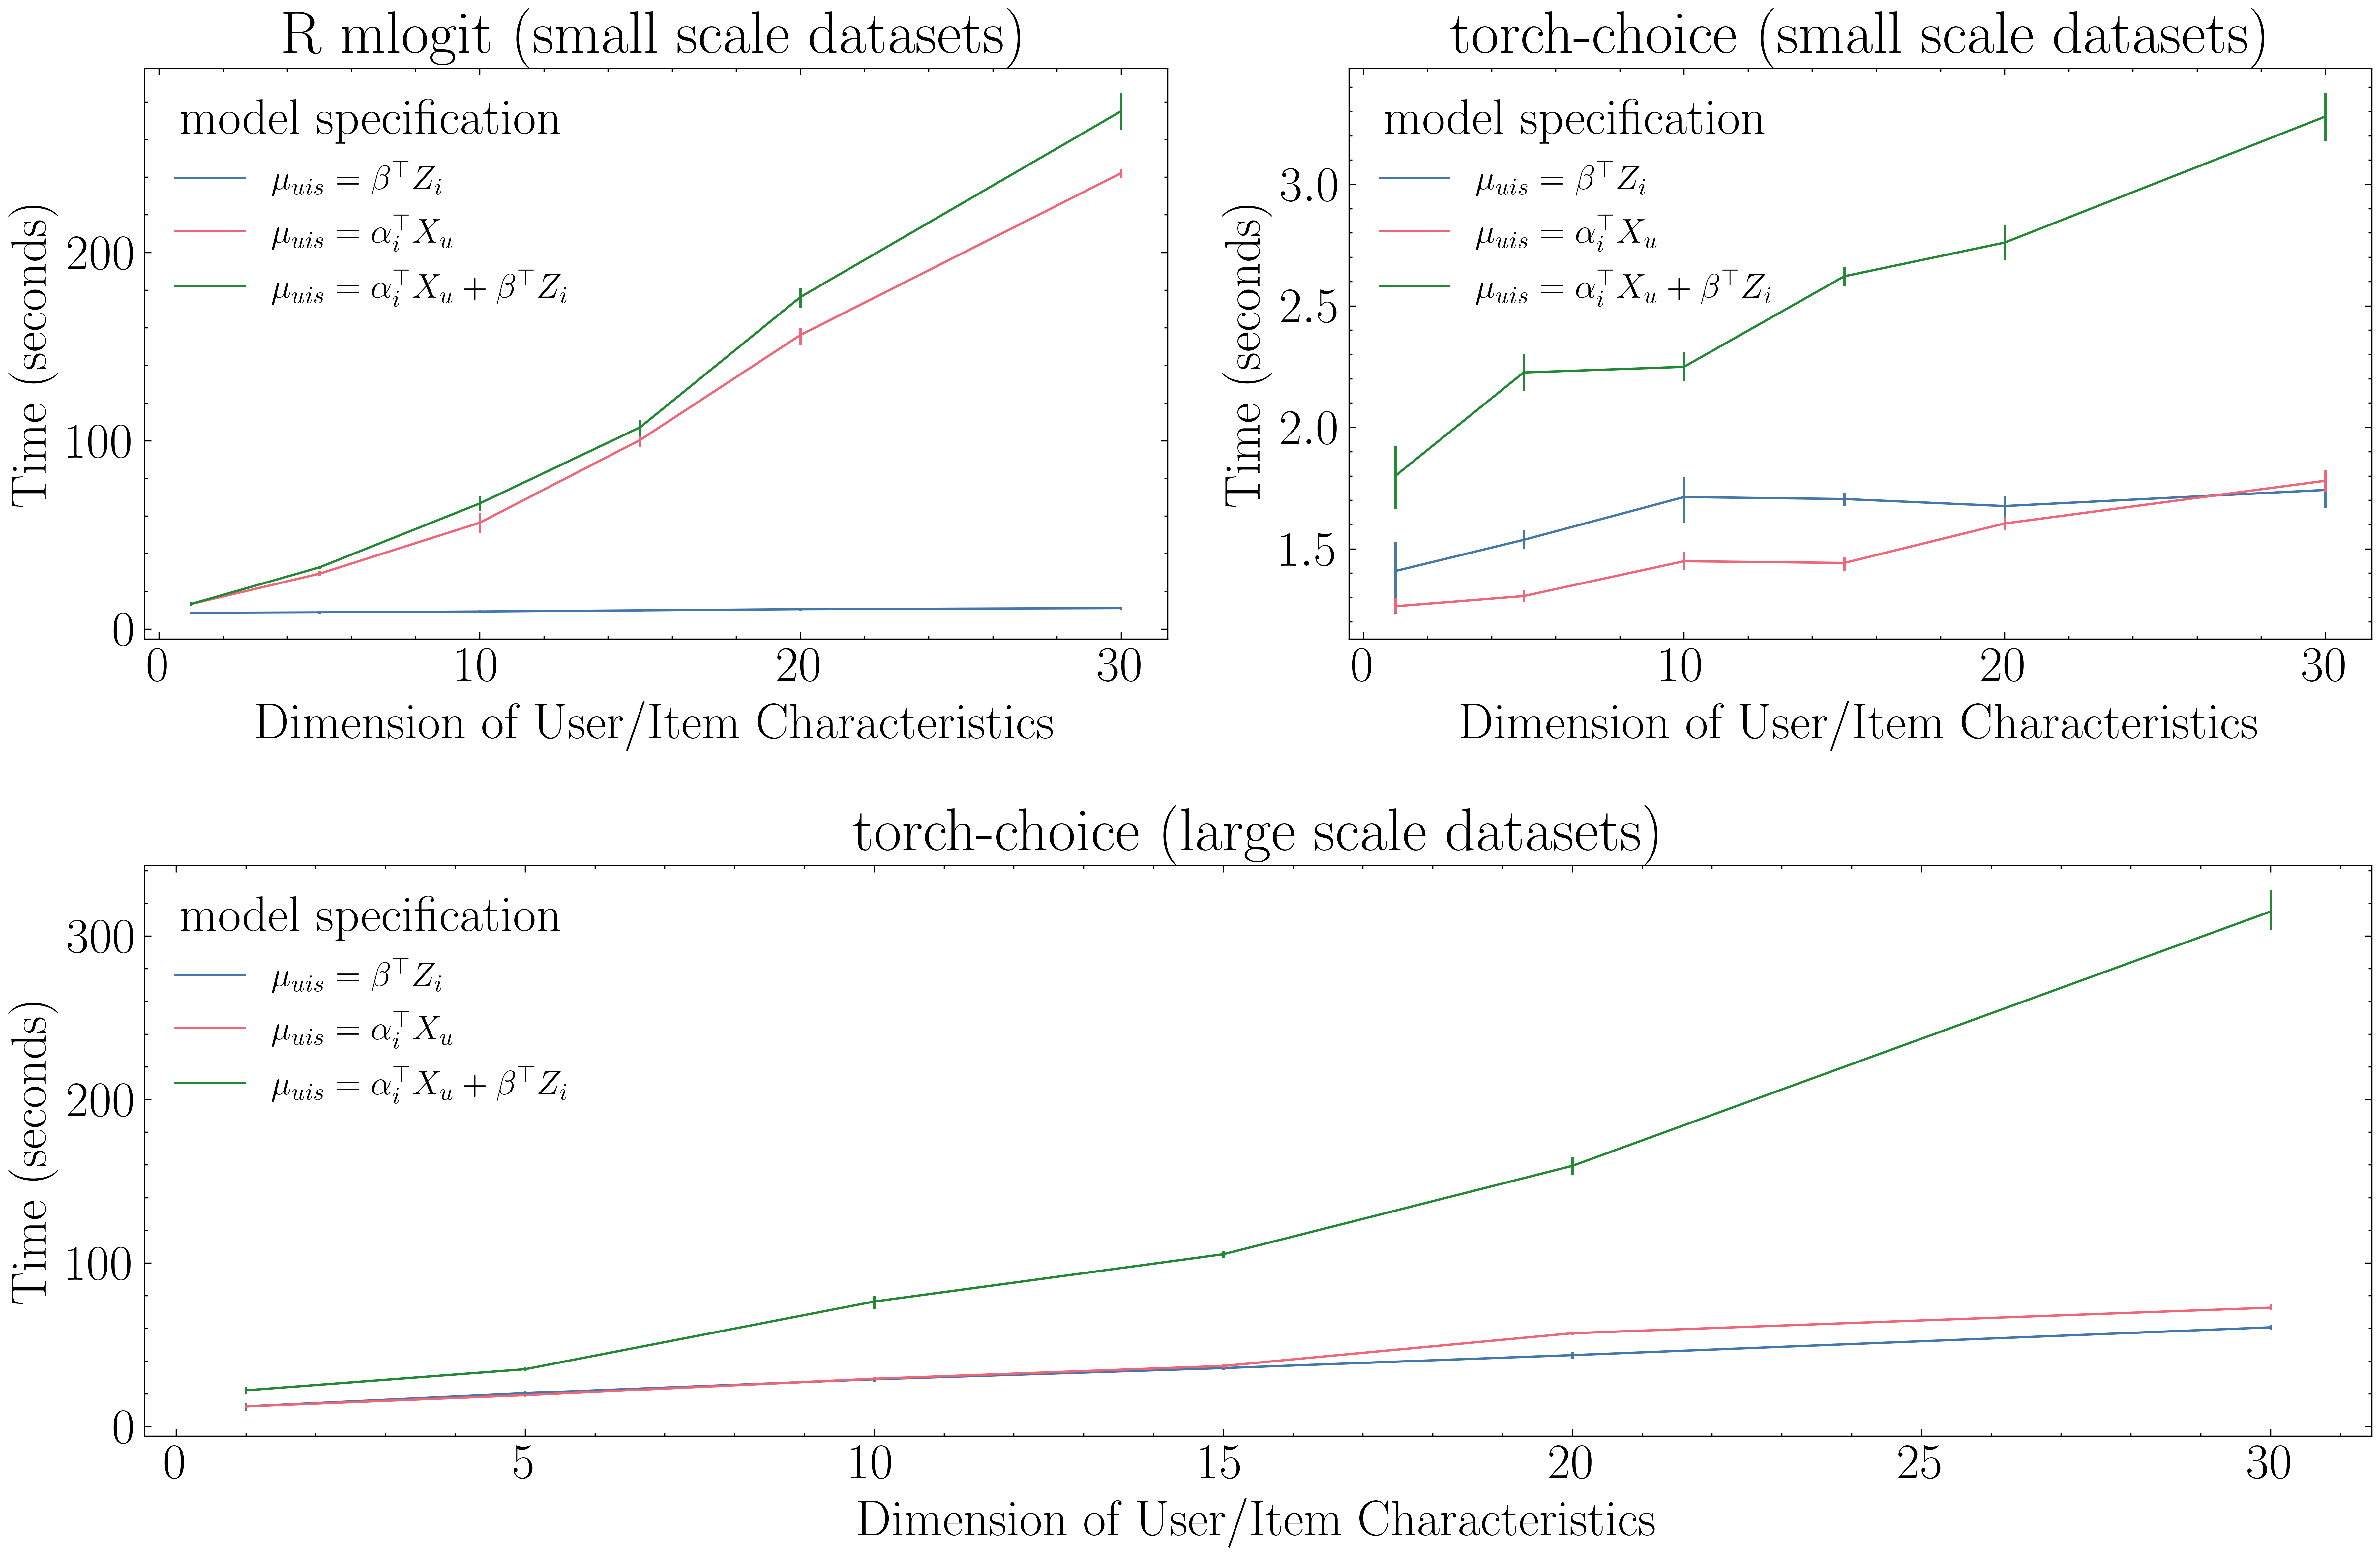

In [19]:
df_r = pd.read_csv("R_performance_num_params.csv")
df_r["package"] = "R"
df_python = pd.read_csv(f"Python_num_params_experiment_small{file_appendix}.csv")
df_python["package"] = "Python"

df_r["formula"] = df_r["formula"].apply(parse_r_formula)
if REPORT_RATIO:
    df_r = transform_time_to_ratio(df_r)
    df_python = transform_time_to_ratio(df_python)
    
fig = plt.figure(tight_layout=True, figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)
axes = list()
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, :]))

df_r["model specification"] = df_r["formula"].apply(generate_latex_representation_formula)
df_python["model specification"] = df_python["formula"].apply(generate_latex_representation_formula)

sns.lineplot(x="num_params", y="time", hue="model specification", err_style="bars", data=df_r.sort_values(by="formula"), ax=axes[0])
sns.lineplot(x="num_params", y="time", hue="model specification", err_style="bars", data=df_python.sort_values(by="formula"), ax=axes[1])


for i in range(3):
    axes[i].set_xlabel("Dimension of User/Item Characteristics")
    axes[i].set_ylabel(Y_LABEL)
axes[0].set_title("R mlogit (small scale datasets)")
axes[1].set_title("torch-choice (small scale datasets)")
axes[2].set_title("torch-choice (large scale datasets)")

df = pd.read_csv(f"Python_num_params_experiment_large{file_appendix}.csv")
df["model specification"] = df["formula"].apply(generate_latex_representation_formula)
if REPORT_RATIO:
    df = transform_time_to_ratio(df)

sns.lineplot(x="num_params", y="time", hue="model specification", err_style="bars", data=df.sort_values(by="formula"), ax=axes[2])
fig.savefig(f"./figures/num_covariates_comparisons{file_appendix}_{'ratio' if REPORT_RATIO else 'abs'}.png", bbox_inches="tight")

# Performance by Number of Items ($I$)

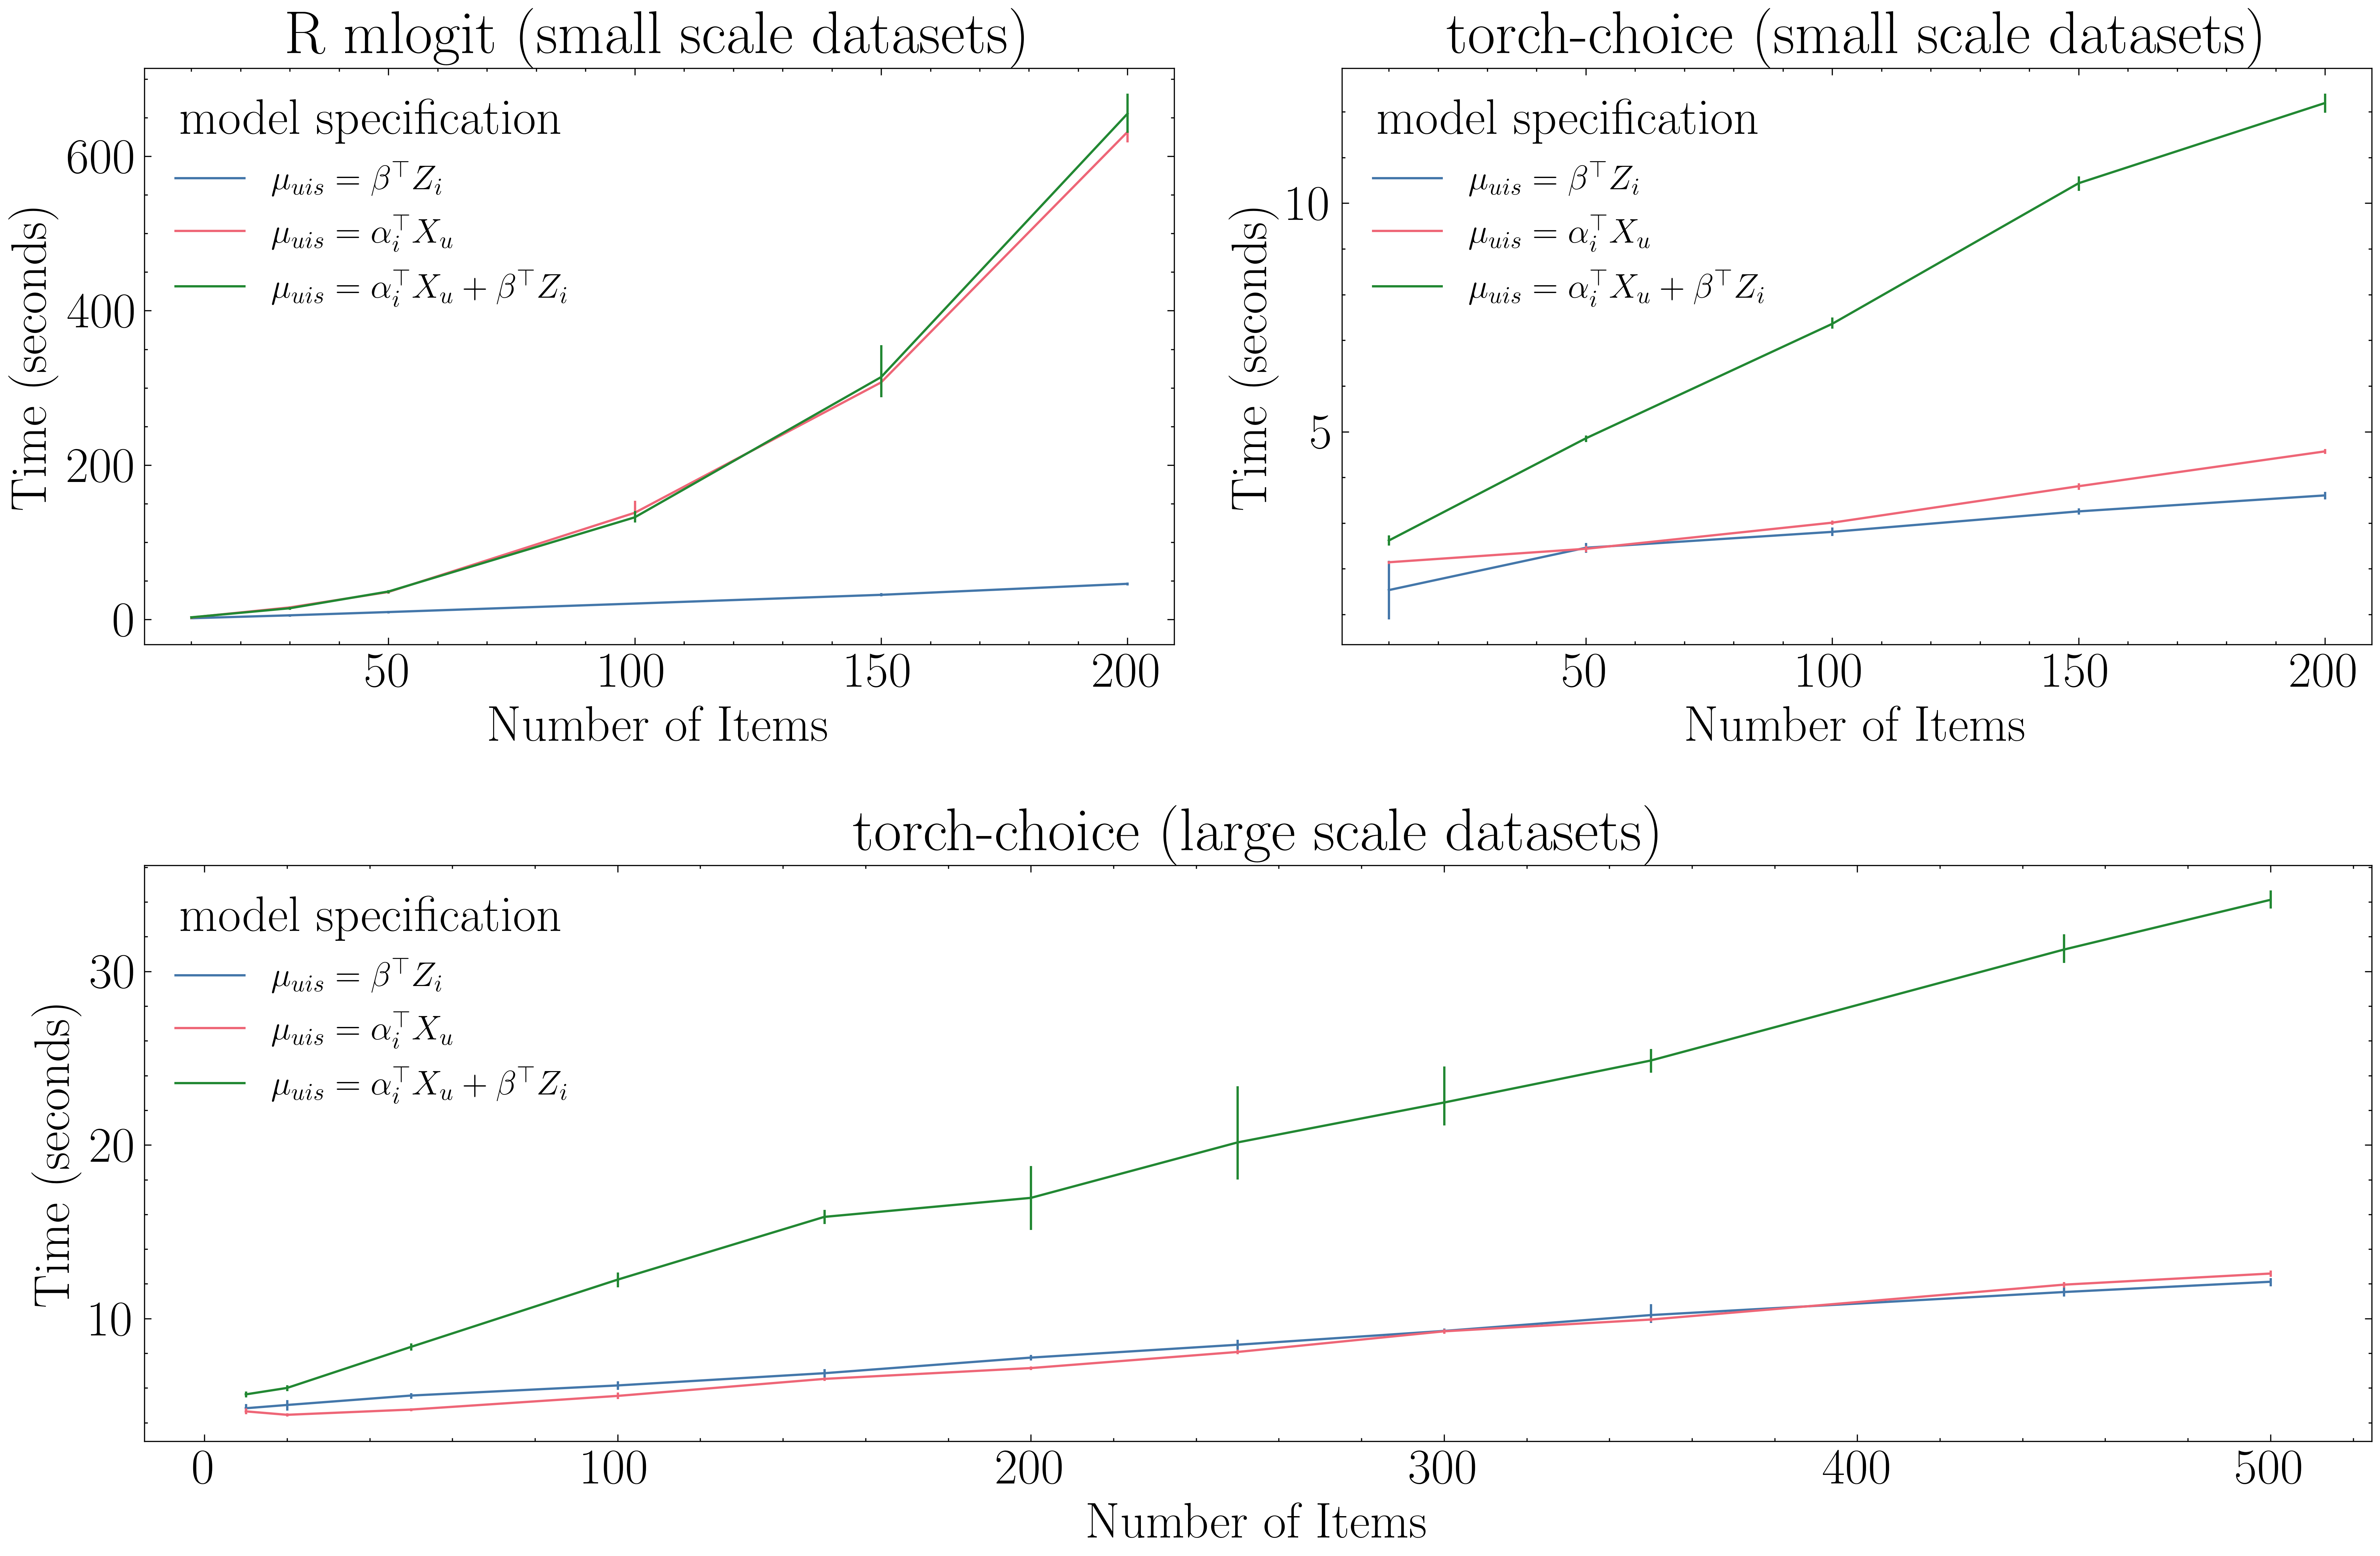

In [20]:
df_r = pd.read_csv("R_performance_num_items.csv")
df_r["package"] = "R"
df_python = pd.read_csv(f"Python_num_items_experiment_small{file_appendix}.csv")
df_python["package"] = "Python"

df_r["r_formula"] = df_r["formula"]
df_r["formula"] = df_r["formula"].apply(parse_r_formula)

if REPORT_RATIO:
    df_r = transform_time_to_ratio(df_r)
    df_python = transform_time_to_ratio(df_python)

fig = plt.figure(tight_layout=True, figsize=(15, 10))
gs = gridspec.GridSpec(2, 2)
axes = list()
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[1, :]))

df_r["model specification"] = df_r["formula"].apply(generate_latex_representation_formula)
df_python["model specification"] = df_python["formula"].apply(generate_latex_representation_formula)

sns.lineplot(x="num_items", y="time", hue="model specification", err_style="bars", data=df_r.sort_values(by="formula"), ax=axes[0])
sns.lineplot(x="num_items", y="time", hue="model specification", err_style="bars", data=df_python.sort_values(by="formula"), ax=axes[1])
axes[0].set_title("R")
axes[1].set_title("torch-choice")

for i in range(3):
    axes[i].set_xlabel("Number of Items")
    axes[i].set_ylabel(Y_LABEL)


df = pd.read_csv(f"Python_num_items_experiment_large{file_appendix}.csv")
df["model specification"] = df["formula"].apply(generate_latex_representation_formula)
if REPORT_RATIO:
    df = transform_time_to_ratio(df)

sns.lineplot(x="num_items", y="time", hue="model specification", err_style="bars", data=df.sort_values(by="formula"), ax=axes[2])

axes[0].set_title("R mlogit (small scale datasets)")
axes[1].set_title("torch-choice (small scale datasets)")
axes[2].set_title("torch-choice (large scale datasets)")

fig.savefig(f"./figures/num_items_comparisons{file_appendix}_{'ratio' if REPORT_RATIO else 'abs'}.png", bbox_inches="tight")